In [1]:
import os
from astropy.table import Table, vstack
from astropy.io import ascii
import scipy, pylab
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_brick_fn(brick_id):
    return fn

def get_obj_row(brick_id, obj_id):
    return row

In [3]:
os.listdir('/scratch/jgreco/tractor/343');

In [4]:
legacyid = Table.read("legacy-brick-id.csv")

lsbg_tab = Table()

for i in range(len(legacyid['brick'])):
    brick = legacyid['brick'][i]      # get brick number and objid from the csv file for Johnny's objects
    objid = legacyid['objid'][i]      # get objid from the csv file for Johnny's objects
    trctr = brick[0:3]                # cut out first three digits to get the tractor file number
    
    fname = '/scratch/jgreco/tractor/%s/tractor-%s.fits' %(trctr, brick)
    
    tab = Table.read(fname)           # create a table for each filename
    
    lsbg_tab = vstack([lsbg_tab, tab[objid]])   # stack every desired row into the lsbg table for reference


In [5]:
lsbg_tab["flux_r"];

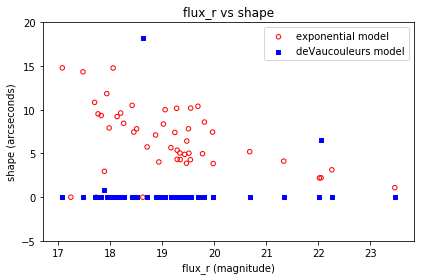

In [8]:
#------make the plot of the different lsbg shapes versus flux (in magnitude)----#
ax1 = pylab.subplot(111)

indxs = []



for i in range(len(lsbg_tab["flux_r"])):                             # get rid of any zero flux values
    if lsbg_tab["flux_r"][i] > 0:
        indxs.append(i)
        
exp = np.zeros(len(indxs))                                       # exponential half-light radius
dev = np.zeros(len(indxs))                                       # deVaucouleur radius
flux_mag = np.zeros(len(indxs))
        
for i in range(len(indxs)):
    exp[i] = lsbg_tab["shapeexp_r"][indxs[i]]
    dev[i] = lsbg_tab["shapedev_r"][indxs[i]]
    flux_mag[i] = 22.5 - 2.5*np.log10(lsbg_tab["flux_r"][indxs[i]]) # convert nanomaggies to flux magnitudes
 
ax1.scatter(flux_mag, exp, s=20, facecolors='none', edgecolors='r', label='exponential model')
ax1.scatter(flux_mag, dev, s=20, c = 'b', marker = "s", label = 'deVaucouleurs model')




#plt.xlim((20, 23.8))
plt.ylim((-5, 20))
plt.title('flux_r vs shape')
plt.xlabel('flux_r (magnitude)')
plt.ylabel('shape (arcseconds)')

plt.legend(loc='best')
plt.tight_layout()

plt.show()

/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


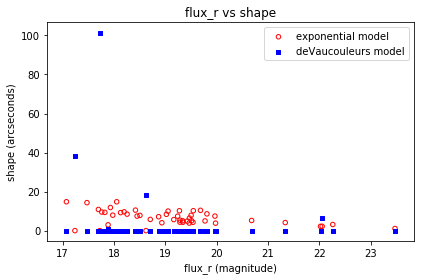

In [10]:
#------make the plot of the different lsbg shapes versus flux (in magnitude)----#
ax1 = pylab.subplot(111)



flux_mag = 22.5 - 2.5*np.log10(lsbg_tab['flux_r'])

 
ax1.scatter(flux_mag, lsbg_tab['shapeexp_r'], s=20, facecolors='none', edgecolors='r', label='exponential model')
ax1.scatter(flux_mag, lsbg_tab['shapedev_r'], s=20, c = 'b', marker = "s", label = 'deVaucouleurs model')



#pylab.ylim([40.8, 42.0])
#pylab.xlim([])
plt.title('flux_r vs shape')
plt.xlabel('flux_r (magnitude)')
plt.ylabel('shape (arcseconds)')

plt.legend(loc='best')
plt.tight_layout()

plt.show()

In [29]:
directory = "/scratch/jgreco/tractor/191"

big_table = Table()

for fname in os.listdir(directory):
    filename = os.fsdecode(fname)
    
    if filename.endswith(".fits"):
        print(os.path.join(directory, filename))
        
        file = os.path.join(directory, filename)
        
        table = Table.read(file)
        
        big_table = vstack([big_table, table])


/scratch/jgreco/tractor/191/tractor-1910m092.fits


/scratch/jgreco/tractor/191/tractor-1910m095.fits
/scratch/jgreco/tractor/191/tractor-1910m097.fits


/scratch/jgreco/tractor/191/tractor-1910p092.fits


/scratch/jgreco/tractor/191/tractor-1910p095.fits
/scratch/jgreco/tractor/191/tractor-1910p097.fits
/scratch/jgreco/tractor/191/tractor-1910p100.fits
/scratch/jgreco/tractor/191/tractor-1910p102.fits
/scratch/jgreco/tractor/191/tractor-1910p105.fits
/scratch/jgreco/tractor/191/tractor-1910p107.fits
/scratch/jgreco/tractor/191/tractor-1910p110.fits
/scratch/jgreco/tractor/191/tractor-1910p112.fits
/scratch/jgreco/tractor/191/tractor-1910p115.fits
/scratch/jgreco/tractor/191/tractor-1910p117.fits
/scratch/jgreco/tractor/191/tractor-1910p155.fits
/scratch/jgreco/tractor/191/tractor-1910p157.fits
/scratch/jgreco/tractor/191/tractor-1910p160.fits
/scratch/jgreco/tractor/191/tractor-1910p162.fits
/scratch/jgreco/tractor/191/tractor-1910p165.fits
/scratch/jgreco/tractor/191/tractor-1910p167.fits
/scratch/jgreco/tractor/191/tractor-1910p197.fits
/scratch/jgreco/tractor/191/tractor-1910p200.fits
/scratch/jgreco/tractor/191/tractor-1910p202.fits
/scratch/jgreco/tractor/191/tractor-1910p205.fits


/scratch/jgreco/tractor/191/tractor-1910p267.fits
/scratch/jgreco/tractor/191/tractor-1910p270.fits


/scratch/jgreco/tractor/191/tractor-1910p272.fits
/scratch/jgreco/tractor/191/tractor-1910p292.fits


/scratch/jgreco/tractor/191/tractor-1910p295.fits
/scratch/jgreco/tractor/191/tractor-1910p297.fits
/scratch/jgreco/tractor/191/tractor-1910p300.fits
/scratch/jgreco/tractor/191/tractor-1910p320.fits
/scratch/jgreco/tractor/191/tractor-1910p322.fits
/scratch/jgreco/tractor/191/tractor-1910p325.fits
/scratch/jgreco/tractor/191/tractor-1911m002.fits


/scratch/jgreco/tractor/191/tractor-1911m005.fits
/scratch/jgreco/tractor/191/tractor-1911m007.fits
/scratch/jgreco/tractor/191/tractor-1911m010.fits
/scratch/jgreco/tractor/191/tractor-1911m012.fits


KeyboardInterrupt: 

/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


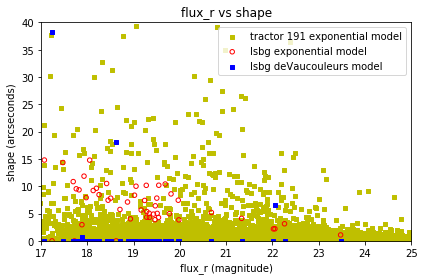

In [40]:
#------make the plot of the different lsbg shapes versus flux (in magnitude) with comparison objects----#
ax1 = pylab.subplot(111)



flux_mag = 22.5 - 2.5*np.log10(lsbg_tab['flux_r'])

tractor_flux = 22.5 - 2.5*np.log10(big_table['flux_r'])
 
ax1.scatter(tractor_flux, big_table['shapeexp_r'], s=10, c = 'y', marker = "s", label = 'tractor 191 exponential model')

ax1.scatter(flux_mag, lsbg_tab['shapeexp_r'], s=20, facecolors='none', edgecolors='r', label='lsbg exponential model')
ax1.scatter(flux_mag, lsbg_tab['shapedev_r'], s=20, c = 'b', marker = "s", label = 'lsbg deVaucouleurs model')


plt.xlim((17, 25))
plt.ylim((0, 40))
plt.title('flux_r vs shape')
plt.xlabel('flux_r (magnitude)')
plt.ylabel('shape (arcseconds)')

plt.legend(loc='best')
plt.tight_layout()

plt.show()

In [ ]:
legacyid = Table.read("legacy-brick-id.csv")

lsbg_tab = Table()

for i in range(len(legacyid['brick'])):
    brick = legacyid['brick'][i]      # get brick number and objid from the csv file for Johnny's objects
    objid = legacyid['objid'][i]      # get objid from the csv file for Johnny's objects
    trctr = brick[0:3]                # cut out first three digits to get the tractor file number
    
    fname = '/scratch/jgreco/tractor/%s/tractor-%s.fits' %(trctr, brick)
    
    tab = Table.read(fname)           # create a table for each filename
    
    lsbg_tab = vstack([lsbg_tab, tab[objid]])   # stack every desired row into the lsbg table for reference

In [23]:
os.listdir('/scratch/jgreco/tractor/343')

In [9]:
ascii.write(lsbg_tab, 'legacy-data.csv', format='csv', fast_writer=False, overwrite=True)

In [ ]:
brick = "3376m005"
objid = 5738

In [58]:
trctr = brick[0:3]   #take out the first three digits of the brick to get the tractor number

In [59]:
fname = '/scratch/jgreco/tractor/%s/tractor-%s.fits' %(trctr, brick)
print(fname)

/scratch/jgreco/tractor/337/tractor-3376m005.fits


In [60]:
tab = Table.read(fname)

In [61]:
tab[objid]


release,brickid,brickname,objid,brick_primary,type,ra,dec,ra_ivar,dec_ivar,bx,by,dchisq [5],ebv,mjd_min,mjd_max,flux_u,flux_g,flux_r,flux_i,flux_z,flux_Y,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_u,flux_ivar_g,flux_ivar_r,flux_ivar_i,flux_ivar_z,flux_ivar_Y,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,apflux_u [8],apflux_g [8],apflux_r [8],apflux_i [8],apflux_z [8],apflux_Y [8],apflux_resid_u [8],apflux_resid_g [8],apflux_resid_r [8],apflux_resid_i [8],apflux_resid_z [8],apflux_resid_Y [8],apflux_ivar_u [8],apflux_ivar_g [8],apflux_ivar_r [8],apflux_ivar_i [8],apflux_ivar_z [8],apflux_ivar_Y [8],mw_transmission_u,mw_transmission_g,mw_transmission_r,mw_transmission_i,mw_transmission_z,mw_transmission_Y,mw_transmission_w1,mw_transmission_w2,mw_transmission_w3,mw_transmission_w4,nobs_u,nobs_g,nobs_r,nobs_i,nobs_z,nobs_Y,nobs_w1,nobs_w2,nobs_w3,nobs_w4,rchisq_u,rchisq_g,rchisq_r,rchisq_i,rchisq_z,rchisq_Y,rchisq_w1,rchisq_w2,rchisq_w3,rchisq_w4,fracflux_u,fracflux_g,fracflux_r,fracflux_i,fracflux_z,fracflux_Y,fracflux_w1,fracflux_w2,fracflux_w3,fracflux_w4,fracmasked_u,fracmasked_g,fracmasked_r,fracmasked_i,fracmasked_z,fracmasked_Y,fracin_u,fracin_g,fracin_r,fracin_i,fracin_z,fracin_Y,anymask_u,anymask_g,anymask_r,anymask_i,anymask_z,anymask_Y,allmask_u,allmask_g,allmask_r,allmask_i,allmask_z,allmask_Y,wisemask_w1,wisemask_w2,psfsize_u,psfsize_g,psfsize_r,psfsize_i,psfsize_z,psfsize_Y,psfdepth_u,psfdepth_g,psfdepth_r,psfdepth_i,psfdepth_z,psfdepth_Y,galdepth_u,galdepth_g,galdepth_r,galdepth_i,galdepth_z,galdepth_Y,wise_coadd_id,lc_flux_w1 [7],lc_flux_w2 [7],lc_flux_ivar_w1 [7],lc_flux_ivar_w2 [7],lc_nobs_w1 [7],lc_nobs_w2 [7],lc_fracflux_w1 [7],lc_fracflux_w2 [7],lc_rchisq_w1 [7],lc_rchisq_w2 [7],lc_mjd_w1 [7],lc_mjd_w2 [7],fracdev,fracdev_ivar,shapeexp_r,shapeexp_r_ivar,shapeexp_e1,shapeexp_e1_ivar,shapeexp_e2,shapeexp_e2_ivar,shapedev_r,shapedev_r_ivar,shapedev_e1,shapedev_e1_ivar,shapedev_e2,shapedev_e2_ivar
,,,,,,deg,deg,1/deg^2,1/deg^2,,,,mag,,,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,,,,,,,,,,,arcsec,1/arcsec^2,,,,,arcsec,1/arcsec^2,,,,
int16,int32,str8,int32,bool,str4,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str8,float32,float32,float32,float32,int16,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,flo

In [33]:
new_tab = Table()
for i in range(len(tab[:50])):
    new_tab = vstack([new_tab, tab[i]])

In [34]:
new_tab

release,brickid,brickname,objid,brick_primary,type,ra,dec,ra_ivar,dec_ivar,bx,by,dchisq [5],ebv,mjd_min,mjd_max,flux_u,flux_g,flux_r,flux_i,flux_z,flux_Y,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_u,flux_ivar_g,flux_ivar_r,flux_ivar_i,flux_ivar_z,flux_ivar_Y,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,apflux_u [8],apflux_g [8],apflux_r [8],apflux_i [8],apflux_z [8],apflux_Y [8],apflux_resid_u [8],apflux_resid_g [8],apflux_resid_r [8],apflux_resid_i [8],apflux_resid_z [8],apflux_resid_Y [8],apflux_ivar_u [8],apflux_ivar_g [8],apflux_ivar_r [8],apflux_ivar_i [8],apflux_ivar_z [8],apflux_ivar_Y [8],mw_transmission_u,mw_transmission_g,mw_transmission_r,mw_transmission_i,mw_transmission_z,mw_transmission_Y,mw_transmission_w1,mw_transmission_w2,mw_transmission_w3,mw_transmission_w4,nobs_u,nobs_g,nobs_r,nobs_i,nobs_z,nobs_Y,nobs_w1,nobs_w2,nobs_w3,nobs_w4,rchisq_u,rchisq_g,rchisq_r,rchisq_i,rchisq_z,rchisq_Y,rchisq_w1,rchisq_w2,rchisq_w3,rchisq_w4,fracflux_u,fracflux_g,fracflux_r,fracflux_i,fracflux_z,fracflux_Y,fracflux_w1,fracflux_w2,fracflux_w3,fracflux_w4,fracmasked_u,fracmasked_g,fracmasked_r,fracmasked_i,fracmasked_z,fracmasked_Y,fracin_u,fracin_g,fracin_r,fracin_i,fracin_z,fracin_Y,anymask_u,anymask_g,anymask_r,anymask_i,anymask_z,anymask_Y,allmask_u,allmask_g,allmask_r,allmask_i,allmask_z,allmask_Y,wisemask_w1,wisemask_w2,psfsize_u,psfsize_g,psfsize_r,psfsize_i,psfsize_z,psfsize_Y,psfdepth_u,psfdepth_g,psfdepth_r,psfdepth_i,psfdepth_z,psfdepth_Y,galdepth_u,galdepth_g,galdepth_r,galdepth_i,galdepth_z,galdepth_Y,wise_coadd_id,lc_flux_w1 [7],lc_flux_w2 [7],lc_flux_ivar_w1 [7],lc_flux_ivar_w2 [7],lc_nobs_w1 [7],lc_nobs_w2 [7],lc_fracflux_w1 [7],lc_fracflux_w2 [7],lc_rchisq_w1 [7],lc_rchisq_w2 [7],lc_mjd_w1 [7],lc_mjd_w2 [7],fracdev,fracdev_ivar,shapeexp_r,shapeexp_r_ivar,shapeexp_e1,shapeexp_e1_ivar,shapeexp_e2,shapeexp_e2_ivar,shapedev_r,shapedev_r_ivar,shapedev_e1,shapedev_e1_ivar,shapedev_e2,shapedev_e2_ivar
,,,,,,deg,deg,1/deg^2,1/deg^2,,,,mag,,,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,,,,,,,,,,,arcsec,1/arcsec^2,,,,,arcsec,1/arcsec^2,,,,
int16,int32,str8,int32,bool,str4,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str8,float32,float32,float32,float32,int16,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,flo